In [ ]:
## MAKE A TABLE OF ALL THE IMPORTANT VALUES FOR EACH STACK in each SUBSTACK etc...

# SNR of each STK_AVG (quality of raw data, potential after denoising)

# Bleed-through (correlation between pixels in the two channels, as well as gof on correlation)

# RANSAC implementation: 


In [ ]:
import tifffile

def read_tif_stack(filename):
    """Reads a .tif image stack into a 3D NumPy array.

    Args:
        filename: The path to the .tif file.

    Returns:
        A 3D NumPy array containing the image stack.
    """

    with tifffile.TiffFile(filename) as tif:
        return tif.asarray()

In [ ]:
import os
import numpy as np

root = "C:\\Users\\svw191\\PythonFiles\\PythonTrial\\LED +APs 240926\\240926_pl100_pc001_LED+APs500microW_ex01\\DATA\\"
filename_A = "ChanA\\ChanA_stk.tif"
filename_B = "ChanB\\ChanB_stk.tif"
# stack = read_tif_stack(os.path.join(root,filename))

tif_stk_A = read_tif_stack(os.path.join(root, filename_A))
tif_stk_B = read_tif_stack(os.path.join(root, filename_B))


In [ ]:
tif_stk_avg_A = np.mean(tif_stk_A, axis=0)
tif_stk_avg_B = np.mean(tif_stk_B, axis=0)

In [ ]:
tif_stk_avg_flat_A = tif_stk_avg_A.flatten()
tif_stk_avg_flat_B = tif_stk_avg_B.flatten()

In [ ]:
# calculate SNR form Fourier Space
import numpy as np
import scipy.fftpack as fft

def calculate_snr_frequency_domain(image):
    # Convert to grayscale if necessary
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Perform Fourier Transform
    f_image = fft.fft2(gray_image)

    # Shift zero-frequency component to center
    f_shifted = fft.fftshift(f_image)

    # Calculate power spectrum
    power_spectrum = np.abs(f_shifted)**2

    # Define a threshold to separate signal and noise (adjust as needed)
    threshold = np.mean(power_spectrum)

    # Create masks for signal and noise regions
    signal_mask = power_spectrum > threshold
    noise_mask = power_spectrum <= threshold

    # Calculate power of signal and noise
    power_signal = np.sum(power_spectrum[signal_mask])
    power_noise = np.sum(power_spectrum[noise_mask])

    # Calculate SNR
    snr = power_signal / power_noise

    return snr

In [ ]:
SNR_FT = calculate_snr_frequency_domain(tif_stk_avg_B)
print(f'SNR_FT = {SNR_FT}')

In [5]:
# RANSAC implementation
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor
from sklearn.metrics import r2_score
import tifffile

# x = tif_stk_avg_flat_A
# y = tif_stk_avg_flat_B

root = "C:\\Users\\svw191\\PythonFiles\\PythonTrial\\LED +APs 240926\\240926_pl100_pc001_LED+APs500microW_ex01\\DATA\\"
filename_A = "ChanA\\ChanA_stk_avg.tif"
filename_B = "ChanB\\ChanB_stk_avg.tif"
A = tifffile.imread(os.path.join(root, filename_A), key=0)
B = tifffile.imread(os.path.join(root, filename_B), key=0)
x = A.flatten()
y = B.flatten()

# Create a RANSAC regressor
ransac = RANSACRegressor(min_samples=25, residual_threshold=5.0, random_state=0)
ransac.fit(x[:, np.newaxis], y)

# Get inlier and outlier masks
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Calculate correlation coefficient using only inliers
inlier_x = x[inlier_mask]
inlier_y = y[inlier_mask]
correlation_coefficient = np.corrcoef(inlier_x, inlier_y)[0, 1]

print(f"Size of inlier mask: {np.count_nonzero(inlier_mask)}")
print(f"Size of outlier mask: {np.count_nonzero(outlier_mask)}")

print(inlier_mask[0:9])

Size of inlier mask: 242451
Size of outlier mask: 19693
[ True  True  True  True  True  True  True  True  True]


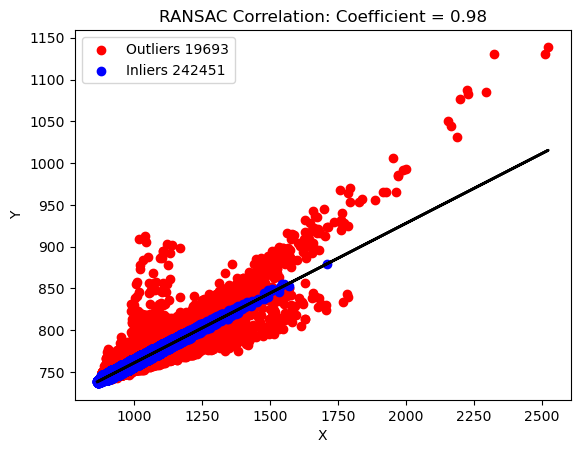

In [10]:
# Plot the results
plt.scatter(x[outlier_mask], y[outlier_mask], color='red', label=f"Outliers {sum(outlier_mask)}")
plt.scatter(x[inlier_mask], y[inlier_mask], color='blue', label=f"Inliers {sum(inlier_mask)}")
plt.plot(x,ransac.predict(x[:, np.newaxis]), color='black', linewidth=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'RANSAC Correlation: Coefficient = {correlation_coefficient:.2f}')
plt.legend()
plt.show()

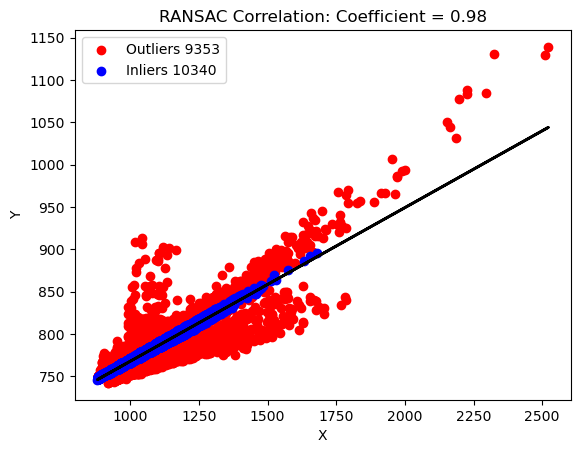

Size of inlier mask: 10340
Size of outlier mask: 9353


In [13]:
# Run RANSAC of the remainders in outlier_mask (split into channels??)

x2 = np.copy(x[outlier_mask])
y2 = np.copy(y[outlier_mask])

# Create a RANSAC regressor
rsc2 = RANSACRegressor(min_samples=25, residual_threshold=5.0, random_state=0)
rsc2.fit(x2[:, np.newaxis], y2)

# Get inlier and outlier masks
in_m2 = rsc2.inlier_mask_
out_m2 = np.logical_not(in_m2)

# Calculate correlation coefficient using only inliers
in_x2 = x2[in_m2]
in_y2 = y2[in_m2]
corr_coeff_2 = np.corrcoef(in_x2, in_y2)[0, 1]

# Plot the results
plt.scatter(x2[out_m2], y2[out_m2], color='red', label=f"Outliers {sum(out_m2)}")
plt.scatter(x2[in_m2], y2[in_m2], color='blue', label=f"Inliers {sum(in_m2)}")
plt.plot(x2,rsc2.predict(x2[:, np.newaxis]), color='black', linewidth=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'RANSAC Correlation: Coefficient = {correlation_coefficient:.2f}')
plt.legend()
plt.show()

print(f"Size of inlier mask: {np.count_nonzero(in_m2)}")
print(f"Size of outlier mask: {np.count_nonzero(out_m2)}")

In [ ]:
# Run RANSAC of the remainders in outlier_mask (split into channels??)

x3 = np.copy(x2[out_m2])
y3 = np.copy(y2[out_m2])

# Create a RANSAC regressor
rsc3 = RANSACRegressor(min_samples=25, residual_threshold=5.0, random_state=0)
rsc3.fit(x3[:, np.newaxis], y3)

# Get inlier and outlier masks
in_m3 = rsc3.inlier_mask_
out_m3 = np.logical_not(in_m3)

# Calculate correlation coefficient using only inliers
in_x3 = x3[in_m3]
in_y3 = y3[in_m3]
corr_coeff_3 = np.corrcoef(in_x3, in_y3)[0, 1]

# Plot the results
plt.scatter(x3[out_m3], y3[out_m3], color='red', label='Outliers')
plt.scatter(x3[in_m3], y3[in_m3], color='blue', label='Inliers')
plt.plot(x3,rsc3.predict(x3[:, np.newaxis]), color='black', linewidth=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'RANSAC Correlation: Coefficient = {correlation_coefficient:.2f}')
plt.legend()
plt.show()

print(f"Size of inlier mask: {np.count_nonzero(in_m3)}")
print(f"Size of outlier mask: {np.count_nonzero(out_m3)}")

In [ ]:
# Generate basic loop

from sklearn.linear_model import RANSACRegressor
from matplotlib import pyplot as plt
import numpy as np

fig, axs = plt.subplot(nrows=1, ncols=3)

for t in range(3):
    # input: outlier_mask
    x2 = np.copy(x[outlier_mask])
    y2 = np.copy(y[outlier_mask])
    
    # Create a RANSAC regressor
    rsc_new = RANSACRegressor(min_samples=25, residual_threshold=5.0, random_state=0)
    rsc_new.fit(x_copy[:, np.newaxis], y_copy)
    rsc_out = np.copy(rsc)
    
    


In [ ]:
# Generate a loop within a function

def RANSAC_outlier_analysis(x, y, out_idc, residual_threshold=5.0, min_samples=25, random_state=0):
    x_copy = np.copy(x[out_idc])
    y_copy = np.copy(y[out_idc])
    
    # Create a RANSAC regressor
    rsc_new = RANSACRegressor(min_samples=25, residual_threshold=5.0, random_state=0)
    rsc_new.fit(x_copy[:, np.newaxis], y_copy)
    rsc_out = np.copy(rsc)
    
    # Get inlier and outlier masks
    inlier_mask = rsc.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)
    
    out_idc_new = np.where(outlier_mask)[0]
    
    out_idc_new_converted = out_idc[out_idc_new] # index mismatch
    
    OutMask_new = np.zeros_like(x, dtype=bool)
    OutMask_new[out_idc_new_converted] = True
    InMask_new = np.logical_not(OutMask_new)
    
    # Calculate correlation coefficient using only inliers
    inlier_x = x_copy[inlier_mask]
    inlier_y = y_copy[inlier_mask]
    corr_coeff = np.corrcoef(inlier_x, inlier_y)[0, 1]
    slope, intercept = np.polyfit(inlier_x, inlier_y, 1)
    
    return out_idc_new_converted, corr_coeff, slope, intercept, InMask_new, OutMask_new, rsc


In [ ]:
# TrialMask = [False for _ in range(10)]

# idc = np.array([2,8])

# TrialMask[int(idc)] = True

# TrialMask

In [ ]:
# Apply that to the real data

t = 5
x = tif_stk_avg_flat_A
y = tif_stk_avg_flat_B

corr_coeff = np.corrcoef(x, y)[0, 1]
slope, intercept = np.polyfit(x, y, 1)

# Create a RANSAC regressor
rsc = RANSACRegressor(min_samples=25, residual_threshold=5.0, random_state=0)
rsc.fit(x[:, np.newaxis], y)

Strcs = []
Strc_temp = {
    'Iteration': 0,
    'Out_idc': np.array(range(len(x))),
    'CorrCoeff': corr_coeff,
    'Slope': slope,
    'Intercept': intercept,
    'InlierMask': [False for _ in range(len(x))],
    'OutlierMask': [True for _ in range(len(x))],
    'RSC': rsc
}
Strcs.append(Strc_temp)


for n in range(t):
    out_idc = Strcs[n]['Out_idc']
    out_idc_new_converted, corr_coeff, slope, intercept, InMask_new, OutMask_new, rsc = RANSAC_outlier_analysis(x, y, out_idc)
    Strc_copy = np.copy(Strc_temp)
    Strc_copy = {
        'Iteration': n+1,
        'Out_idc': out_idc_new_converted,
        'CorrCoeff': corr_coeff,
        'Slope': slope,
        'Intercept': intercept,
        'InlierMask': InMask_new,
        'OutlierMask': OutMask_new,
        'RSC': rsc
    }
    Strcs.append(Strc_copy)
    

In [ ]:
# for n in range(6):
#     print(f"Iteration: {Strcs[n]['Iteration']}")
#     print(f"Number of output indices: {len(Strcs[n]['Out_idc'])}")
#     print(f"Slope of correlation: {Strcs[n]['Slope']}")
#     print(f"Length of OutlierMask: {len(Strcs[n]['OutlierMask'])}")
#     print(f"OutlierMask (first10): {Strcs[n]['OutlierMask'][100000:100009]}")

In [ ]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=np.size(Strcs), ncols=3, figsize=(10, 5))

# Display iterations in loops, (A) Correation, (B) Filter ChanA - red, (C) Filtered ChanB - green
for n in range(2): # range(np.size(Strcs)):
    # Plot the results (Correlations first)
    out_idc = Strcs[n]['Out_idc']
    out_mask = Strcs[n]['OutlierMask']
    in_mask = np.logical_not(out_mask)
    rsc = Strcs[n]['RSC']
    axs[n,0].scatter(x[out_mask], y[out_mask], color='red', label='Outliers')
    axs[n,0].scatter(x[in_mask], y[in_mask], color='blue', label='Inliers')
    axs[n,0].plot(x,rsc.predict(x[:, np.newaxis]), color='black', linewidth=2)
    axs[n,0].set_xlabel('X')
    axs[n,0].set_ylabel('Y')
    axs[n,0].set_title(f'RANSAC Correlation: Coefficient = {correlation_coefficient:.2f}')
    axs[n,0].legend()

plt.show()
    

In [ ]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(5, 2))

# Display the first array in the first subplot
axs[0].imshow(tif_stk_avg_A)
axs[0].set_title('ChanA')

tsa_A_filt = np.copy(tif_stk_avg_A)
tsa_A_filt[np.reshape(inlier_mask,(512,512))] = 0

# Display the second array in the second subplot
axs[1].imshow(tsa_A_filt)
axs[1].set_title('ChanB')

plt.show()


In [ ]:
# Trouble-shoot:

# Try without

# Try loop without structure

# Consider implementing the structure (consider, not necessary if output-figure is saved in pdf)